# Coursera Capstone
# The Battle of the Neighborhoods
This document will be used for the Coursera Capstone project, part of the IBM Data Science Professional Certificate.

In [28]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from shapely.geometry import Point, Polygon

import shapely.speedups #For point in polygon calculations
shapely.speedups.enable()

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import K Nearest Neightbors
from sklearn.neighbors import KNeighborsClassifier

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Create a dataframe of neighborhoods in Minneapolis
As far as I could tell, the data for Minneapolis neighborhoods did not come attached with latitude and longitude values. The following section creates a dataframe with neighborhood names and attached lat/long values.

In [29]:
# Data retrieved from
# https://opendata.minneapolismn.gov/datasets/minneapolis-neighborhoods
# Data downloaded and placed in local directory.

with open('Minneapolis_Neighborhoods.geojson.json') as jsondata:
    mpls_data = json.load(jsondata)
    
#with open('Communities.geojson') as jsondata:
 #   mpls_comm_data = json.load(jsondata)
    
with open('stp_neighborhoods.geojson') as jsondata:
    stp_nbhd_data = json.load(jsondata)

In [30]:
# We will refer back to the larger mpls_data dataframe later.
mpls_nbhds = mpls_data['features']
#mpls_comms = mpls_comm_data['features']
stp_nbhds = stp_nbhd_data['features']

Look at the first entry. Note the neighborhood name has key 'BDNAME' for the Minneapolis neighborhoods. The neighborhood name has key 'name2' for the St. Paul neighborhoods. Using these keys, we will build geo dataframes with the columns `Neighborhood`, `Latitude`, and `Longitude`.

#### Populate the latitude and longitude using Geopy

In [34]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_mpls = pd.DataFrame(columns=column_names)

# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in mpls_nbhds:
    nbhd_name = data['properties']['BDNAME']
    df_nbhds_mpls = df_nbhds_mpls.append({'Neighborhood':nbhd_name}, ignore_index=True)

# Populate lat/lon values for neighborhoods. Gather values not found by Geopy.
missing_latlons = []
for nbhd in df_nbhds_mpls['Neighborhood']:
    address = nbhd + ', Minneapolis, MN'
    geolocator = Nominatim(user_agent="geo_explorer")
    location = geolocator.geocode(address)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude
    
print(missing_latlons)
df_nbhds_mpls.head()

Downtown West, Minneapolis, MN is not found on geopy.
Ventura Village, Minneapolis, MN is not found on geopy.
South Uptown, Minneapolis, MN is not found on geopy.
Mid - City Industrial, Minneapolis, MN is not found on geopy.
Nicollet Island - East Bank, Minneapolis, MN is not found on geopy.
['Downtown West', 'Ventura Village', 'South Uptown', 'Mid - City Industrial', 'Nicollet Island - East Bank']


Neighborhood Latitude Longitude
0      Phillips West  44.9539  -93.2663
1      Downtown West      NaN       NaN
2      Downtown East   44.975  -93.2599
3    Ventura Village      NaN       NaN
4  Sumner - Glenwood  44.9837  -93.2914

There are 5 neighborhoods that Geopy could not identify. We can manually input these by pulling the location data from a google search.

In [35]:
# Manually look up missing lat/lon values for these neighborhoods.
Downtown_West =[44.9742, -93.2733]
Ventura_Village = [44.9618, -93.2582]
# This neighborhood is now found on geopy...
#Humboldt_Industrial_Area = [45.0421, -93.3077]
South_Uptown = [44.9411, -93.2911]
Mid_City_Industrial = [44.9989, -93.2178]
Nicollet_Island = [44.9879, -93.2629]

missing_mpls = [Downtown_West, Ventura_Village, South_Uptown, Mid_City_Industrial, Nicollet_Island]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_mpls)):
    entry ={missing_latlons[j]:missing_mpls[j]}
    missing_dict.update(entry)


# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_mpls)):
    value=df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood']==missing_latlons[j]]
    df_nbhds_mpls.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_mpls.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]



## St. Paul Neighborhoods
Repeat the above steps to create a dataframe of the St. Paul neighborhoods.

In [36]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_stp = pd.DataFrame(columns=column_names)


# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in stp_nbhds:
    nbhd_name = data['properties']['name2']
    df_nbhds_stp = df_nbhds_stp.append({'Neighborhood':nbhd_name}, ignore_index=True)
    
# Populate Lat/Long using Geopy
missing_latlons = []
for nbhd in df_nbhds_stp['Neighborhood']:
    address = nbhd + ', St. Paul, MN'
    geolocator = Nominatim(user_agent="geo_explorer")
    location = geolocator.geocode(address)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude

print(missing_latlons)

Macalester-Groveland, St. Paul, MN is not found on geopy.
West Side Community Organization, St. Paul, MN is not found on geopy.
Summit Hill Association, St. Paul, MN is not found on geopy.
Summit-University, St. Paul, MN is not found on geopy.
Thomas-Dale/Frogtown, St. Paul, MN is not found on geopy.
West 7th Federation/Fort Road, St. Paul, MN is not found on geopy.
CapitolRiver Council, St. Paul, MN is not found on geopy.
Payne-Phalen, St. Paul, MN is not found on geopy.
The Greater East Side, St. Paul, MN is not found on geopy.
Eastview-Conway-Battle Creek-Highwood Hills, St. Paul, MN is not found on geopy.
Union Park, St. Paul, MN is not found on geopy.
['Macalester-Groveland', 'West Side Community Organization', 'Summit Hill Association', 'Summit-University', 'Thomas-Dale/Frogtown', 'West 7th Federation/Fort Road', 'CapitolRiver Council', 'Payne-Phalen', 'The Greater East Side', 'Eastview-Conway-Battle Creek-Highwood Hills', 'Union Park']


We manually insert the data for the missing St. Paul neighborhoods.

In [37]:
mac_grove=[44.9343,-93.1670]
west_side_comm_org=[44.9298, -93.0780]
summit_hill = [44.9399, -93.1364]
summit_uni = [44.9518, -93.1263]
thomas_dale_frogtown = [44.9594, -93.1212]
west_seventh = [44.9277, -93.1270]
capitol_river_council = [44.9512, -93.0952]
payne_phalen = [44.9775, -93.0660]
greater_east_side = [44.9741, -93.0240]
eastview_conway = [44.9525, -93.0117]
union_park = [44.9484, -93.1746]

missing_stp = [mac_grove, west_side_comm_org, summit_hill, summit_uni, thomas_dale_frogtown, west_seventh,
             capitol_river_council, payne_phalen, greater_east_side, eastview_conway, union_park ]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_stp)):
    entry ={missing_latlons[j]:missing_stp[j]}
    missing_dict.update(entry)

# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_stp)):
    value=df_nbhds_stp.index[df_nbhds_stp['Neighborhood']==missing_latlons[j]]
    df_nbhds_stp.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_stp.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]

df_nbhds_stp.head()

Neighborhood Latitude Longitude
0       St Anthony Park  44.9792  -93.1935
1                  Como  44.9759  -93.1313
2             North End  32.7843  -96.7971
3        Hamline-Midway  44.9629  -93.1669
4  Macalester-Groveland  44.9343   -93.167

Put the Minneapolis and St. Paul neighborhoods into one dataframe which we will call `nbhds`.

In [39]:
nbhds = pd.concat([df_nbhds_mpls,df_nbhds_stp]).reset_index(drop=True)

## Use FourSquare API to gather data about breweries in Minneapolis

In [40]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']


# Define FourSquare credentials
CLIENT_ID = 'JSN5MX1DKF5XI3CXVZADJMU5LZE5FMLT2COF00LRJDFMFWIK' # your Foursquare ID
CLIENT_SECRET = 'ZST1WYPJCG2J2LGQGUER23BPAC1OMF1BKYC4WQKSSRD3WC1T' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

category = '50327c8591d4c4b30a586d5d' # Foursquare category for brewery
radius = 3500 # in meters
LIMIT = 200

# Initialize df_brew
df_brew =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at a 5 km radius area centered at each of the neighbhorhood lat/lon coordinates.
# Do FourSquare API call for each neighborhood, locating breweries. Store results in df_brew.
for j in range(0,len(nbhds)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
    df_brew = pd.concat([df_brew, df_temp])

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_brew dataframe.    
df_brew.drop(columns=drop_columns, inplace=True)
df_brew.drop_duplicates(inplace=True)
df_brew.reset_index(inplace=True)
print(df_brew.shape)
df_brew.head()

(112, 6)


index                  venue.id                       venue.name  \
0      0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1      1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
2      2  52e6ad8c498efd5a184d1105                  LynLake Brewery   
3      3  5aa9baebff03062a4b1dccba                  Finnegans House   
4      4  52d4225b498e07070c180a62                 Sisyphus Brewing   

  venue.location.address  venue.location.lat  venue.location.lng  
0     920 E Lake St #123           44.948491          -93.260416  
1       1368 Lasalle Ave           44.968908          -93.279479  
2     2934 Lyndale Ave S           44.948919          -93.288345  
3          817 5th Ave S           44.972301          -93.266410  
4      712 Ontario Ave W           44.973214          -93.289040

By looking at the names of the breweries, we identify those that are clearly coffee shops, and remove them from the dataset.

In [44]:
set(df_brew['venue.name'])

{'12welve Eyes Brewing',
 '56 Brewing',
 '612Brew',
 'Able Seedhouse + Brewery',
 'Anvil Pub',
 'Bad Weather Brewing Company',
 'Bang Brewing Company',
 "Barley John's Brewpub",
 'Barrel Theory Beer Company',
 'Bauhaus Brew Labs',
 "Bennett's Chop and Railhouse",
 "Birch's Lowertown",
 'Black & Tan Brewery',
 'BlackStack Brewing',
 'Braindead Brewing',
 'Brewmenn Brewing',
 'Broken Clock Brewing Cooperative',
 'Burning Brothers Brewing',
 'Bus Stop Burgers and Brewhouse',
 'Cane Rosso',
 'Chatterbox Pub',
 'Clockwerks Brewing',
 'Clutch Brewing',
 'Community Beer Company',
 'Craft Beer Corner',
 'Craft and Growler',
 'Dangerous Man Brewing Co',
 'Day Block Brewing Company',
 'Deep Ellum Brewing Company',
 'Dual Citizen Brewing Company',
 "Dusty's Bar",
 'Eastlake Craft Brewery',
 'FINNEGANS Headquarters',
 'Fair State Brewing Cooperative',
 'Fair State Co-op Production Brewery',
 'Falling Knife Brewing',
 'Finnegans House',
 'Flat Earth Brewing Company',
 "Fordham's Beer Company",
 'Fo

In [52]:
# Drop the following venues from df_brew.
venue_brew_drop = {'Metro Warehouse Liquor', 'Pizza Lucé', 'SiP Coffee Bar', 'Spyhouse Coffee'}
for j in venue_brew_drop:
    df_brew.drop(df_brew.index[df_brew['venue.name']==j], inplace=True)
df_brew_copy.shape

(108, 6)

## Use FourSquare API to gather data about restaurants in Twin Cities

In [53]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)
radius = 2000 # in meters
LIMIT = 200

# Initialize df_food
df_food =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at a 2 km radius area centered at each of the Minneapolis neighbhorhoods.
# Do FourSquare API call for each neighborhood, locating restaurants. Store results in df_food.
counter = 0
for j in range(0,len(df_nbhds_mpls)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
#    print('df_temp shape is', df_temp.shape, '. Counter is ', counter)
    df_food = pd.concat([df_food, df_temp])
    print(counter)
    counter+=1
    
# Repeat above call but with St. Paul neighborhoods. Increase the radius size.
radius = 3500
counter = 0
for j in range(0,len(df_nbhds_stp)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
#    print('df_temp shape is', df_temp.shape, '. Counter is ', counter)
    df_food = pd.concat([df_food, df_temp])
    print(counter)
    counter+=1

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_brew dataframe.    
df_food.drop(columns=drop_columns, inplace=True)
df_food.drop_duplicates(inplace=True)
df_food.reset_index(drop=True, inplace=True)
print(df_food.shape)
df_food.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
(1201, 5)


venue.id             venue.name venue.location.address  \
0  44b492d9f964a52057351fe3  Midtown Global Market          920 E Lake St   
1  49fb95f5f964a5205d6e1fe3   Taqueria La Hacienda     334 E Lake St #101   
2  44f1f813f964a5200a381fe3       Quang Restaurant      2719 Nicollet Ave   
3  50255babe4b0bc802b45360b                   FIKA          2600 Park Ave   
4  49e4c13ef964a52034631fe3         Manny's Tortas          920 E Lake St   

   venue.location.lat  venue.location.lng  
0           44.948589          -93.260502  
1           44.948605          -93.271181  
2           44.953136          -93.277745  
3           44.954555          -93.265717  
4           44.948679          -93.260649

## Make geodataframes of the neighborhoods
Minneapolis has neighborhoods and communities. The communities encompass several neighborhoods in general. The area size of the communities is generally closer to the size of the St. Paul neighborhoods.

In [55]:
# Make Minneapolis neighborhoods
mpls_nbhd_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json')
mpls_nbhd_geo = mpls_nbhd_geo[['geometry', 'BDNAME']]
mpls_nbhd_geo['city']=pd.Series(['Minneapolis']*len(mpls_nbhd_geo))

# Minneapolis communities are closer in size to the St. Paul neighborhoods.
# If we prefer to consider Minneapolis communities and St. Paul neighborhoods, comment the above code and
# run the following instead.

#mpls_comm_geo = gpd.read_file('Communities.geojson')
#mpls_comm_geo = mpls_comm_geo[['geometry', 'CommName']]
#mpls_comm_geo['city']=pd.Series(['Minneapolis']*len(mpls_comm_geo))
#mpls_comm_geo.rename(columns={'CommName':'BDNAME'}, inplace=True) # Rename so columns match

# Make St. Paul neighborhoods
stp_geo = gpd.read_file('stp_neighborhoods.geojson')
stp_geo = stp_geo[['geometry', 'name2']]
stp_geo.rename(columns={'name2':'BDNAME'}, inplace=True) # Rename so columns match
stp_geo['city']=pd.Series(['St. Paul']*len(stp_geo))

# Combine to twin cities neighborhoods
tc_geo=pd.concat([mpls_nbhd_geo, stp_geo]).drop_duplicates().reset_index(drop=True)
print(tc_geo.shape)
tc_geo.head()

(104, 3)


geometry             BDNAME  \
0  MULTIPOLYGON (((-93.26258 44.96091, -93.26258 ...      Phillips West   
1  MULTIPOLYGON (((-93.26011 44.98300, -93.26010 ...      Downtown West   
2  MULTIPOLYGON (((-93.24499 44.97893, -93.24499 ...      Downtown East   
3  MULTIPOLYGON (((-93.24958 44.96630, -93.24951 ...    Ventura Village   
4  MULTIPOLYGON (((-93.28830 44.98904, -93.28830 ...  Sumner - Glenwood   

          city  
0  Minneapolis  
1  Minneapolis  
2  Minneapolis  
3  Minneapolis  
4  Minneapolis

## Assign neighborhoods and communities to breweries and neighborhoods

In [ ]:
def get_nbhd(index):
    return nbhds.loc[index, 'Neighborhood']

brew_dict={}
# Identify brewery neighborhoods
# Return dictionary with brewery names as keys, neighborhoods as values.
for j in range(0,len(nbhds)):
    nbhd_temp = tc_geo[tc_geo['BDNAME']==get_nbhd(j)]
    nbhd_temp.reset_index(drop=True, inplace=True)
#    print(nbhd_temp)
    for index in range(0, len(df_brew)):
        nbhd_temp_mask = nbhd_temp.loc[0,'geometry'].contains(df_brew_geo['geometry'][index])
#        print(nbhd_temp_mask)
#        nbhd_temp_mask = df_brew_geo['geometry'][index].within(nbhd_temp.loc[0,'geometry'])
        if nbhd_temp_mask == True:           
            print('Brewery {} is in {}'.format(df_brew_geo['venue.name'][index], nbhd_temp.loc[0,'BDNAME'] ))
            brew_dict[df_brew_geo['venue.name'][index]]=get_nbhd(j)

brew_dict        

## Visualizing breweries and neighborhoods
The neighborhood data is not attached to the brewery locations. To generate the Choropleth map, we would need this. It could be done manually, but that may be more effort than I want. On the other hand, should be able to overlay the neighborhood grids with the brewery markers.


In [61]:
address = 'Minneapolis, MN'
geolocator = Nominatim(user_agent="mn_explorer")
location = geolocator.geocode(address)
mpls_latitude=location.latitude
mpls_longitude=location.longitude

address = 'St. Paul, MN'
geolocator = Nominatim(user_agent="mn_explorer")
location = geolocator.geocode(address)
stp_latitude=location.latitude
stp_longitude=location.longitude

# Center the map between the two cities.
avg_lat = (mpls_latitude + stp_latitude)/2
avg_lon = (mpls_longitude + stp_longitude)/2
 
tc_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=12, tiles='Stamen Terrain')
tc_map

## Add neighborhoods to map

In [62]:
## Minneapolis communities
#folium.GeoJson(mpls_comm_data).add_to(tc_map)

# Minneapolis neighborhoods
folium.GeoJson(mpls_data).add_to(tc_map)

# St. Paul neighborhoods
folium.GeoJson(stp_nbhd_data).add_to(tc_map)

In [63]:
tc_map

#### Add breweries to map

In [119]:
# Create brewery instances
breweries = folium.map.FeatureGroup()

# add breweries to map
for lat, lon in zip(df_brew['venue.location.lat'], df_brew['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='blue',
        fill=True,
#        popup=label,
        fill_color='magenta',
        fill_opacity=0.6
    ).add_to(tc_map)

#### Add restaurants to map

In [114]:
# Create restaurant instances
foods = folium.map.FeatureGroup()

# add breweries to map
for lat, lon in zip(df_food['venue.location.lat'], df_food['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='orange',
        fill=True,
#        popup=label,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(tc_map)

In [120]:
tc_map

#### Cluster restaurants
This code may be skipped when running. At the moment, not sure it adds too much other than clutter.

In [121]:
restaurant_cluster = plugins.MarkerCluster().add_to(tc_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng in zip(df_food['venue.location.lat'], df_food['venue.location.lng']):
    folium.Marker(
        location=[lat, lng],
        icon=None
#        popup=label,
    ).add_to(restaurant_cluster)
tc_map

## CLuster restaurant regions vs brewery regions

Supervised: restaurant vs brewery
high density brewery vs high density restaurant
Want to build brewery in region lots of restaurants, low brewery density.

This section needs work still. But Geopandas is now up and running?


In [170]:
df_food['type'] = pd.Series(np.zeros(len(df_food)))
df_food.head()

venue.id             venue.name venue.location.address  \
0  44b492d9f964a52057351fe3  Midtown Global Market          920 E Lake St   
1  49fb95f5f964a5205d6e1fe3   Taqueria La Hacienda     334 E Lake St #101   
2  44f1f813f964a5200a381fe3       Quang Restaurant      2719 Nicollet Ave   
3  54937ac5498e25e66df4a4ed      Black Sheep Pizza      2550 Nicollet Ave   
4  51254ee3e4b0597635a30975       Glam Doll Donuts      2605 Nicollet Ave   

   venue.location.lat  venue.location.lng                    geometry  type  
0           44.948589          -93.260502  POINT (-93.26050 44.94859)   0.0  
1           44.948605          -93.271181  POINT (-93.27118 44.94861)   0.0  
2           44.953136          -93.277745  POINT (-93.27774 44.95314)   0.0  
3           44.955667          -93.278022  POINT (-93.27802 44.95567)   0.0  
4           44.955156          -93.277816  POINT (-93.27782 44.95516)   0.0

In [171]:
df_brew['type'] = pd.Series(np.ones(len(df_brew)))
df_brew.head()

index                  venue.id                       venue.name  \
0      0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1      1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
2      2  52e6ad8c498efd5a184d1105                  LynLake Brewery   
3      3  5aa9baebff03062a4b1dccba                  Finnegans House   
4      4  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   

  venue.location.address  venue.location.lat  venue.location.lng  \
0     920 E Lake St #123           44.948491          -93.260416   
1       1368 Lasalle Ave           44.968908          -93.279479   
2     2934 Lyndale Ave S           44.948919          -93.288345   
3          817 5th Ave S           44.972301          -93.266410   
4          414 6th Ave N           44.984862          -93.278828   

                     geometry      Neighborhood  type  
0  POINT (-93.26042 44.94849)  Midtown Phillips   1.0  
1  POINT (-93.27948 44.96891)       Loring Park   1.0  
2  POINT (-93.28834 44.94892)   Lowry Hill East   1.0  
3  POINT (-93.26641 44.97230)       Elliot Park   1.0  
4  POINT (-93.27883 44.98486)        North Loop   1.0

In [172]:
df_brew.drop(columns=['index'], inplace=True)
df_brew.head(2)

venue.id                       venue.name  \
0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   

  venue.location.address  venue.location.lat  venue.location.lng  \
0     920 E Lake St #123           44.948491          -93.260416   
1       1368 Lasalle Ave           44.968908          -93.279479   

                     geometry      Neighborhood  type  
0  POINT (-93.26042 44.94849)  Midtown Phillips   1.0  
1  POINT (-93.27948 44.96891)       Loring Park   1.0

In [173]:
XX = pd.concat([df_food, df_brew]).reset_index(drop=True)
print(XX.head())
print(XX.tail())

                   venue.id             venue.name venue.location.address  \
0  44b492d9f964a52057351fe3  Midtown Global Market          920 E Lake St   
1  49fb95f5f964a5205d6e1fe3   Taqueria La Hacienda     334 E Lake St #101   
2  44f1f813f964a5200a381fe3       Quang Restaurant      2719 Nicollet Ave   
3  54937ac5498e25e66df4a4ed      Black Sheep Pizza      2550 Nicollet Ave   
4  51254ee3e4b0597635a30975       Glam Doll Donuts      2605 Nicollet Ave   

   venue.location.lat  venue.location.lng                    geometry  type  \
0           44.948589          -93.260502  POINT (-93.26050 44.94859)   0.0   
1           44.948605          -93.271181  POINT (-93.27118 44.94861)   0.0   
2           44.953136          -93.277745  POINT (-93.27774 44.95314)   0.0   
3           44.955667          -93.278022  POINT (-93.27802 44.95567)   0.0   
4           44.955156          -93.277816  POINT (-93.27782 44.95516)   0.0   

  Neighborhood  
0          NaN  
1          NaN  
2          

venue.location.lat  venue.location.lng  type
314           44.962178          -93.274213   1.0
315           44.939535          -93.239138   1.0
316           45.010180          -93.252054   1.0
317           44.998394          -93.221090   1.0
318           44.989450          -93.241404   1.0

In [256]:
X = XX.values

In [257]:
X = X[:,0:2]
y = XX['type'].values
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1.

In [272]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

k=15
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [0.3125     0.28125    0.28125    0.203125   0.22222222]


In [294]:
k=10
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)

yhat = neigh.predict(X_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7764705882352941
Test set Accuracy:  0.828125


In [275]:
 my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

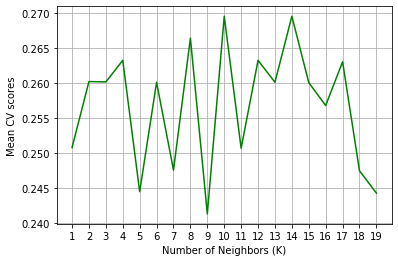

In [282]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

mean_scores=[]

for n in range(1,Ks):
    #Train Model and Predict  
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=n))])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    mean_scores.append(scores.mean())

#    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
#    yhat=neigh.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
#    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#mean_acc

plt.plot(range(1,Ks),mean_scores,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
#plt.legend(('Accuracy ', '+/- 3xstd'))
#plt.ylabel('Accuracy ')
plt.ylabel('Mean CV scores')
plt.xlabel('Number of Neighbors (K)')
plt.xticks(range(1,Ks))
plt.grid()
#plt.tight_layout()
plt.show()

In [285]:
print(mean_scores[9])
print(mean_scores[13])

0.2695436507936508
0.2695436507936508


Use 10 neighbors or 14 neighbors.

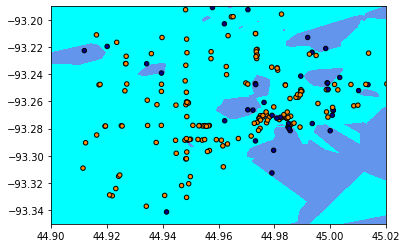

In [312]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

#n_neighbors = 
k=2
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
yhat = neigh.predict(X_test)

# import some data to play with
#iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
#X = iris.data[:, :2]
#y = iris.target

h = 0.0001  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

#for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    #clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    #clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = 44.9, 45.02
y_min, y_max = -93.35, -93.19
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
yhat = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
yhat = yhat.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i, weights = '%s')"
#              % (n_neighbors, weights))

plt.show()

In [293]:
[(XX['venue.location.lat'].max()-XX['venue.location.lat'].min())/100, (XX['venue.location.lng'].max()-XX['venue.location.lng'].min())/100]

[0.0035138193599135547, 0.005493405446240019]

## Choropleth map of brewery density using Geopandas

In [44]:
# Make Minneapolis neighborhoods
#mpls_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json')
#mpls_geo = mpls_geo[['geometry', 'BDNAME']]
#mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))

# Minneapolis communities are closer in size to the St. Paul neighborhoods.
# If we prefer to consider Minneapolis communities and St. Paul neighborhoods, comment the above code and
# run the following instead.

mpls_geo = gpd.read_file('Communities.geojson')
mpls_geo = mpls_geo[['geometry', 'CommName']]
mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))
mpls_geo.rename(columns={'CommName':'BDNAME'}, inplace=True) # Rename so columns match

# Make St. Paul neighborhoods
stp_geo = gpd.read_file('stp_neighborhoods.geojson')
stp_geo = stp_geo[['geometry', 'name2']]
stp_geo.rename(columns={'name2':'BDNAME'}, inplace=True) # Rename so columns match
stp_geo['city']=pd.Series(['St. Paul']*len(stp_geo))

# Combine to twin cities neighborhoods
tc_geo=pd.concat([mpls_geo, stp_geo]).drop_duplicates().reset_index(drop=True)
print(tc_geo.shape)
tc_geo.head()

(28, 3)


geometry      BDNAME         city
0  MULTIPOLYGON (((-93.31949 45.05125, -93.31823 ...      Camden  Minneapolis
1  MULTIPOLYGON (((-93.22685 45.01322, -93.22685 ...   Northeast  Minneapolis
2  MULTIPOLYGON (((-93.31784 45.01326, -93.31744 ...  Near North  Minneapolis
3  MULTIPOLYGON (((-93.27211 44.99213, -93.27157 ...     Central  Minneapolis
4  MULTIPOLYGON (((-93.20761 45.00153, -93.20760 ...  University  Minneapolis

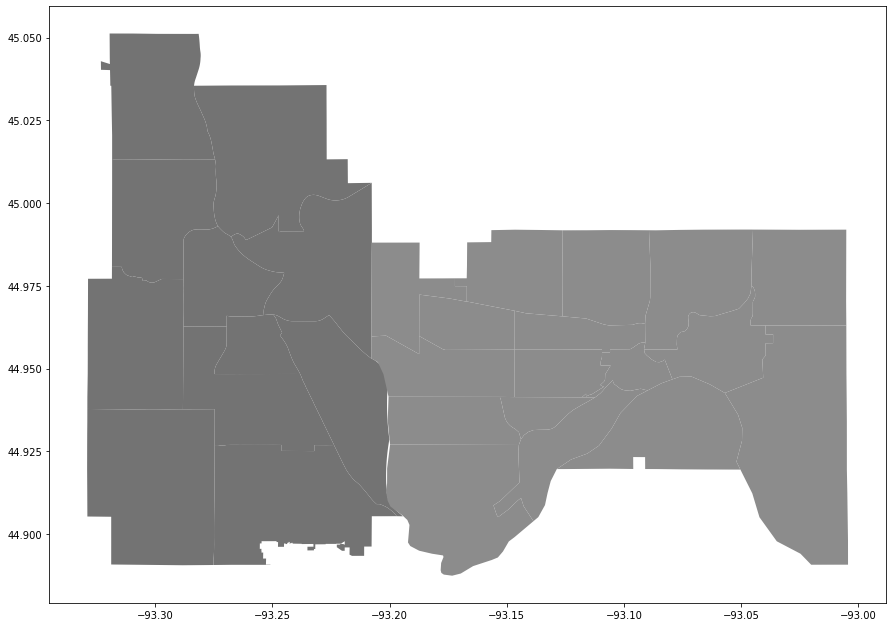

In [45]:
fig, ax = plt.subplots(figsize = (15,15))
#tc_geo.plot(ax=ax, facecolor='black')
mpls_geo.plot(ax=ax, facecolor='.45') # color between 0 and 1 is greyscale. 0 is darker. 1 is lighter.
stp_geo.plot(ax=ax, facecolor='.55')

#### Turn df_brew in geodataframe and count breweries in neighborhoods

In [155]:
# Turn df_brew into geodatafram
df_brew_geo = gpd.GeoDataFrame(df_brew, geometry=gpd.points_from_xy(df_brew['venue.location.lng'], df_brew['venue.location.lat']))
print(len(df_brew_geo))

brewery_count=[]
for j in range(0,len(tc_geo)):
    nbhd = tc_geo.loc[j,'BDNAME']  # nbhd is jth neighborhood name, string
    nbhd_geo = tc_geo[tc_geo['BDNAME'] == nbhd]  # nbhd_geo is jth row
    nbhd_geo.reset_index(drop=True, inplace=True)  # reset index of dataframe
    nbhd_mask = df_brew_geo['geometry'].within(nbhd_geo.loc[0,'geometry'])  # Boolean mask of breweries in nbhd.
    brewery_count.append(sum(nbhd_mask))  # create list of brewery counts per neighborhood.

# Add column to tc_geo    
tc_geo['Brewery Count'] = pd.Series(brewery_count) # add brewery count column

120


Text(0.5, 1, 'Choropleth map of breweries in Minneapolis communities and St. Paul neighborhoods')

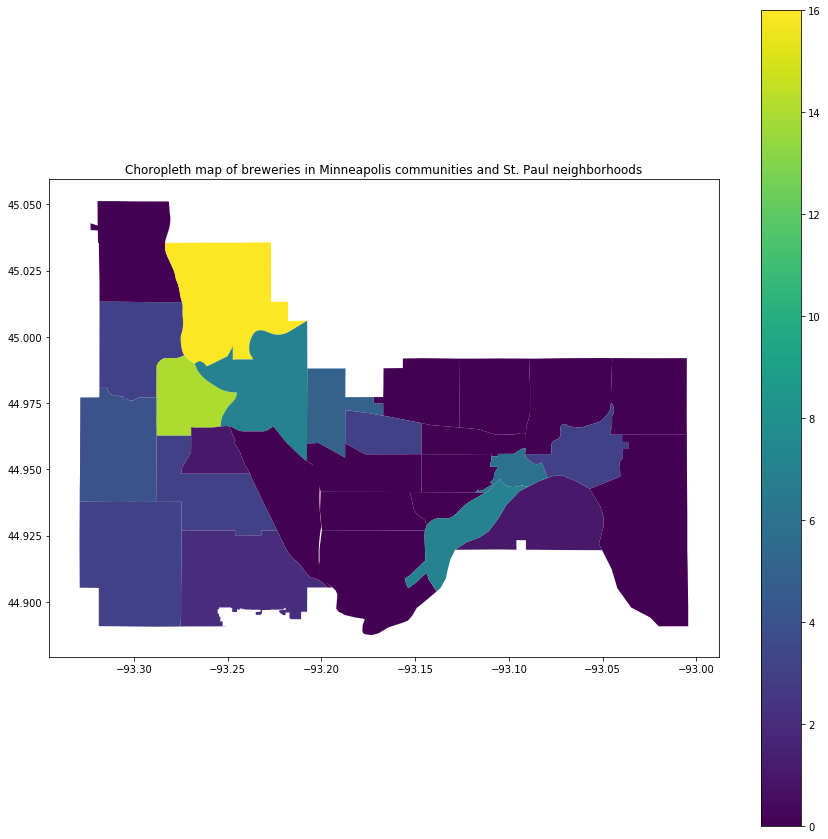

In [55]:
fig, ax = plt.subplots(figsize = (15,15))
#tc_geo.plot(ax=ax, facecolor='black')
#mpls_geo.plot(ax=ax, facecolor='.45') # color between 0 and 1 is greyscale. 0 is darker. 1 is lighter.
#stp_geo.plot(ax=ax, facecolor='.55')
tc_geo.plot(column='Brewery Count', ax=ax, legend=True)
plt.title('Choropleth map of breweries in Minneapolis communities and St. Paul neighborhoods')

## Choropleth map of restaurant density

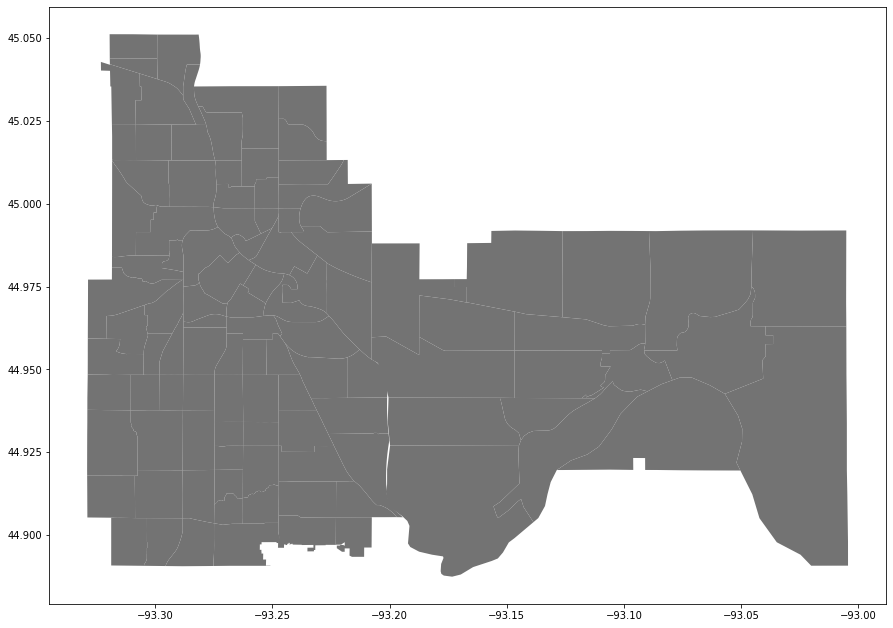

In [67]:
# Make Minneapolis neighborhoods
mpls_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json')
mpls_geo = mpls_geo[['geometry', 'BDNAME']]
mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))

# Minneapolis communities are closer in size to the St. Paul neighborhoods.
# If we prefer to consider Minneapolis communities and St. Paul neighborhoods, comment the above code and
# run the following instead.

#mpls_geo = gpd.read_file('Communities.geojson')
#mpls_geo = mpls_geo[['geometry', 'CommName']]
#mpls_geo['city']=pd.Series(['Minneapolis']*len(mpls_geo))
#mpls_geo.rename(columns={'CommName':'BDNAME'}, inplace=True) # Rename so columns match

# Make St. Paul neighborhoods
stp_geo = gpd.read_file('stp_neighborhoods.geojson')
stp_geo = stp_geo[['geometry', 'name2']]
stp_geo.rename(columns={'name2':'BDNAME'}, inplace=True) # Rename so columns match
stp_geo['city']=pd.Series(['St. Paul']*len(stp_geo))

# Combine to twin cities neighborhoods
tc_geo=pd.concat([mpls_geo, stp_geo]).drop_duplicates().reset_index(drop=True)

# Plot twin city neighborhoods
fig, ax = plt.subplots(figsize = (15,15))
tc_geo.plot(ax=ax, facecolor='.45')
#mpls_geo.plot(ax=ax, facecolor='.45') # color between 0 and 1 is greyscale. 0 is darker. 1 is lighter.
#stp_geo.plot(ax=ax, facecolor='.55')

# save file
plt.savefig('tc_map_gpd.png', bbox_inches='tight')

In [168]:
# Turn df_food into geodataframe
df_food_geo = gpd.GeoDataFrame(df_food, geometry=gpd.points_from_xy(df_food['venue.location.lng'], df_food['venue.location.lat']))

food_count=[]
for j in range(0,len(tc_geo)):
    nbhd = tc_geo.loc[j,'BDNAME']  # nbhd is jth neighborhood name, string
    nbhd_geo = tc_geo[tc_geo['BDNAME'] == nbhd]  # nbhd_geo is jth row
    nbhd_geo.reset_index(drop=True, inplace=True)  # reset index of dataframe
    nbhd_mask = df_food_geo['geometry'].within(nbhd_geo.loc[0,'geometry'])  # Boolean mask of breweries in nbhd.
    food_count.append(sum(nbhd_mask))  # create list of brewery counts per neighborhood.

# Add column to tc_geo    
tc_geo['Restaurant Count'] = pd.Series(food_count) # add brewery count column

Text(0.5, 1, 'Choropleth map of restaurants in Minneapolis communities and St. Paul neighborhoods')

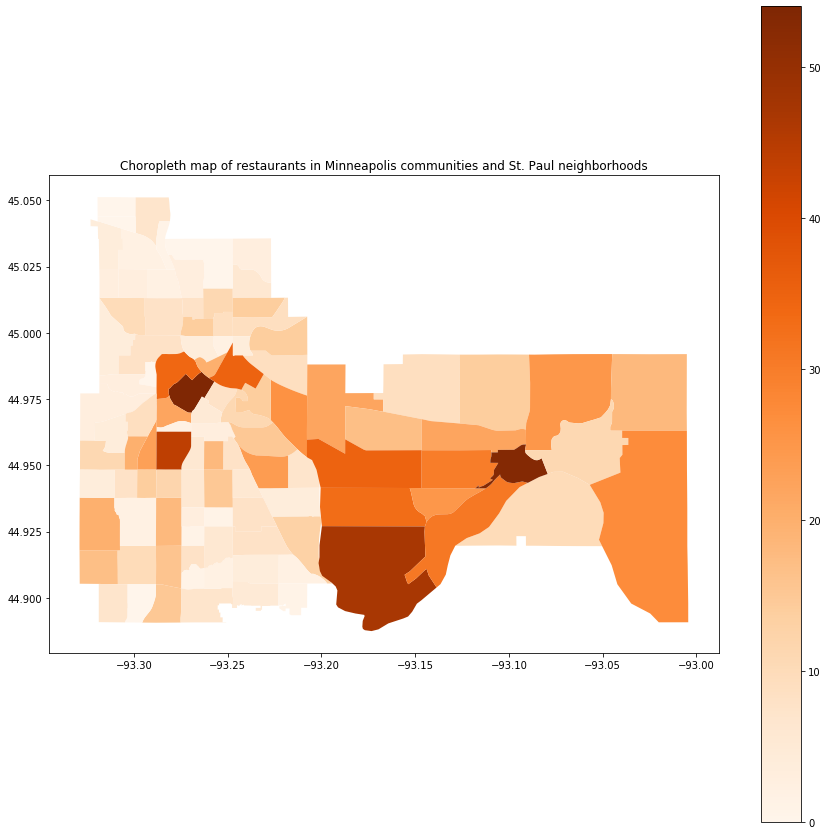

In [169]:

fig, ax = plt.subplots(figsize = (15,15))
tc_geo.plot(column='Restaurant Count', ax=ax, legend=True, cmap='Oranges')
plt.title('Choropleth map of restaurants in Minneapolis communities and St. Paul neighborhoods')

## Put breweries into their neighborhoods/communities 

In [144]:
nbhds.loc[0,'Neighborhood']

'Phillips West'

In [147]:
tc_geo[tc_geo['BDNAME']==get_nbhd(0)]

Empty GeoDataFrame
Columns: [geometry, BDNAME, city, Restaurant Count]
Index: []

In [156]:
print(len(nbhds))
print(len(df_brew))
print(len(df_brew_geo))

104
120
120


In [159]:
def get_nbhd(index):
    return nbhds.loc[index, 'Neighborhood']

brew_dict={}
# Identify brewery neighborhoods
# Return dictionary with brewery names as keys, neighborhoods as values.
for j in range(0,len(nbhds)):
    nbhd_temp = tc_geo[tc_geo['BDNAME']==get_nbhd(j)]
    nbhd_temp.reset_index(drop=True, inplace=True)
#    print(nbhd_temp)
    for index in range(0, len(df_brew)):
        nbhd_temp_mask = nbhd_temp.loc[0,'geometry'].contains(df_brew_geo['geometry'][index])
#        print(nbhd_temp_mask)
#        nbhd_temp_mask = df_brew_geo['geometry'][index].within(nbhd_temp.loc[0,'geometry'])
        if nbhd_temp_mask == True:           
            print('Brewery {} is in {}'.format(df_brew_geo['venue.name'][index], nbhd_temp.loc[0,'BDNAME'] ))
            brew_dict[df_brew_geo['venue.name'][index]]=get_nbhd(j)

brew_dict        

Brewery HopCat is in Downtown West
Brewery Clockwerks Brewing is in Downtown West
Brewery Jackson's Hole is in Downtown West
Brewery Day Block Brewing Company is in Downtown East
Brewery Bus Stop Burgers and Brewhouse is in Downtown East
Brewery Wild Mind Artisan Ales is in Windom
Brewery Northern Brewer is in Windom
Brewery Venn Brewing is in Ericsson
Brewery Minneapolis Town Hall Brewery is in Cedar Riverside
Brewery Republic is in Cedar Riverside
Brewery Surly Brewing Company is in Prospect Park - East River Road
Brewery Pryes Brewing Company is in Near - North
Brewery Utepils Brewing Co. is in Harrison
Brewery La Dona Cerveceri­a is in Harrison
Brewery Lakes & Legends Brewing Company is in Loring Park
Brewery Town Hall Lanes is in Minnehaha
Brewery Fulton Brewing Company is in North Loop
Brewery Inbound BrewCo is in North Loop
Brewery Modist Brewing Co is in North Loop
Brewery The Freehouse is in North Loop
Brewery Number 12 Cider is in North Loop
Brewery ONE Fermentary & Taproom i

{'HopCat': 'Downtown West',
 'Clockwerks Brewing': 'Downtown West',
 "Jackson's Hole": 'Downtown West',
 'Day Block Brewing Company': 'Downtown East',
 'Bus Stop Burgers and Brewhouse': 'Downtown East',
 'Wild Mind Artisan Ales': 'Windom',
 'Northern Brewer': 'Windom',
 'Venn Brewing': 'Ericsson',
 'Minneapolis Town Hall Brewery': 'Cedar Riverside',
 'Republic': 'Cedar Riverside',
 'Surly Brewing Company': 'Prospect Park - East River Road',
 'Pryes Brewing Company': 'Near - North',
 'Utepils Brewing Co.': 'Harrison',
 'La Dona Cerveceri\xada': 'Harrison',
 'Lakes & Legends Brewing Company': 'Loring Park',
 'Town Hall Lanes': 'Minnehaha',
 'Fulton Brewing Company': 'North Loop',
 'Inbound BrewCo': 'North Loop',
 'Modist Brewing Co': 'North Loop',
 'The Freehouse': 'North Loop',
 'Number 12 Cider': 'North Loop',
 'ONE Fermentary & Taproom': 'North Loop',
 "Fordham's Beer Company": 'Fulton',
 'Northbound Smokehouse and Brewpub': 'Standish',
 'LynLake Brewery': 'Lowry Hill East',
 'The Her

In [160]:
# Take our brew_dict and turn it into a DataFrame.
brew_dict=pd.DataFrame.from_dict(brew_dict, orient='index', columns=['Neighborhood'])
brew_dict.reset_index(inplace=True)
brew_dict.rename(columns={'index':'venue.name'}, inplace=True)
brew_dict.head()

venue.name   Neighborhood
0                          HopCat  Downtown West
1              Clockwerks Brewing  Downtown West
2                  Jackson's Hole  Downtown West
3       Day Block Brewing Company  Downtown East
4  Bus Stop Burgers and Brewhouse  Downtown East

In [161]:
df_brew = pd.merge(df_brew, brew_dict, on='venue.name')
df_brew.head()

index                  venue.id                       venue.name  \
0      0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1      1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
2      2  52e6ad8c498efd5a184d1105                  LynLake Brewery   
3      3  5aa9baebff03062a4b1dccba                  Finnegans House   
4      4  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   

  venue.location.address  venue.location.lat  venue.location.lng  \
0     920 E Lake St #123           44.948491          -93.260416   
1       1368 Lasalle Ave           44.968908          -93.279479   
2     2934 Lyndale Ave S           44.948919          -93.288345   
3          817 5th Ave S           44.972301          -93.266410   
4          414 6th Ave N           44.984862          -93.278828   

                     geometry      Neighborhood  
0  POINT (-93.26042 44.94849)  Midtown Phillips  
1  POINT (-93.27948 44.96891)       Loring Park  
2  POINT (-93.28834 44.94892)   Lowry Hill East  
3  POINT (-93.26641 44.97230)       Elliot Park  
4  POINT (-93.27883 44.98486)        North Loop

In [162]:
df_brew.set_index('venue.name')
df_brew.head()

index                  venue.id                       venue.name  \
0      0  538bf392498e382b6fa108b4           Eastlake Craft Brewery   
1      1  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
2      2  52e6ad8c498efd5a184d1105                  LynLake Brewery   
3      3  5aa9baebff03062a4b1dccba                  Finnegans House   
4      4  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   

  venue.location.address  venue.location.lat  venue.location.lng  \
0     920 E Lake St #123           44.948491          -93.260416   
1       1368 Lasalle Ave           44.968908          -93.279479   
2     2934 Lyndale Ave S           44.948919          -93.288345   
3          817 5th Ave S           44.972301          -93.266410   
4          414 6th Ave N           44.984862          -93.278828   

                     geometry      Neighborhood  
0  POINT (-93.26042 44.94849)  Midtown Phillips  
1  POINT (-93.27948 44.96891)       Loring Park  
2  POINT (-93.28834 44.94892)   Lowry Hill East  
3  POINT (-93.26641 44.97230)       Elliot Park  
4  POINT (-93.27883 44.98486)        North Loop

In [192]:
df_brew.drop(columns=['lonlat', 'Neighborhood_x', 'Neighborhood_y'], inplace=True)

In [193]:
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          414 6th Ave N           44.984862          -93.278828   
1         1300 2nd St NE           45.001049          -93.266337   
2     520 Malcolm Ave SE           44.973226          -93.210072   
3       1368 Lasalle Ave           44.968908          -93.279479   
4          817 5th Ave S           44.972301          -93.266410   

                     geometry                     Neighborhood  
0  POINT (-93.27883 44.98486)                       North Loop  
1  POINT (-93.26634 45.00105)                         Sheridan  
2  POINT (-93.21007 44.97323)  Prospect Park - East River Road  
3  POINT (-93.27948 44.96891)                      Loring Park  
4  POINT (-93.26641 44.97230)                      Elliot Park

## Choropleth

In [163]:
df_tc_brew=pd.DataFrame(df_brew['Neighborhood'].value_counts())

In [164]:
df_tc_brew = df_tc_brew.reset_index()

In [165]:
df_tc_brew.head(3)

index  Neighborhood
0  West 7th Federation/Fort Road             7
1                     North Loop             6
2           CapitolRiver Council             6

In [166]:
df_tc_brew.rename(columns={'index':'Neighborhood','Neighborhood':'Brewery Count'}, inplace=True)
df_tc_brew.head()

Neighborhood  Brewery Count
0  West 7th Federation/Fort Road              7
1                     North Loop              6
2           CapitolRiver Council              6
3                St Anthony Park              5
4                 Dayton's Bluff              5

In [186]:
nbhds.to_csv('nbhds_larger.csv')

In [8]:
print(len(df_nbhds_mpls['Neighborhood']))
for j in df_nbhds_mpls['Neighborhood'].sort_values():
    print(j)

87
Armatage
Audubon Park
Bancroft
Beltrami
Bottineau
Bryant
Bryn - Mawr
Camden Industrial
Cedar - Isles - Dean
Cedar Riverside
Central
Cleveland
Columbia Park
Como
Cooper
Corcoran
Diamond Lake
Downtown East
Downtown West
ECCO
East Harriet
East Isles
East Phillips
Elliot Park
Ericsson
Field
Folwell
Fulton
Hale
Harrison
Hawthorne
Hiawatha
Holland
Howe
Humboldt Industrial Area
Jordan
Keewaydin
Kenny
Kenwood
King Field
Lind - Bohanon
Linden Hills
Logan Park
Longfellow
Loring Park
Lowry Hill
Lowry Hill East
Lyndale
Lynnhurst
Marcy Holmes
Marshall Terrace
McKinley
Mid - City Industrial
Midtown Phillips
Minnehaha
Morris Park
Near - North
Nicollet Island - East Bank
North Loop
Northeast Park
Northrop
Page
Phillips West
Powderhorn Park
Prospect Park - East River Road
Regina
Seward
Sheridan
Shingle Creek
South Uptown
St. Anthony East
St. Anthony West
Standish
Steven's Square - Loring Heights
Sumner - Glenwood
Tangletown
University of Minnesota
Ventura Village
Victory
Waite Park
Webber - Camden
W

In [14]:
minne = pd.read_csv('df_nbhds.csv')
minne = minne[minne['City'] == 'Minneapolis']
minne.head()

Unnamed: 0  Neighborhood   Latitude  Longitude         City  \
0           0      Armatage  44.897236 -93.310342  Minneapolis   
1           1  Audubon Park  45.018883 -93.236355  Minneapolis   
2           2      Bancroft  44.930570 -93.254929  Minneapolis   
3           3      Beltrami  44.995352 -93.242513  Minneapolis   
4           4     Bottineau  45.010566 -93.269304  Minneapolis   

   ﻿Total population Total population - Share  White White - Share  Of Color  \
0               5101                     100%   4316        84.60%       784   
1               4421                     100%   3474        78.60%       947   
2               3609                     100%   2649        73.40%       960   
3                979                     100%    596        60.90%       439   
4               1669                     100%    867        51.90%       862   

   ... Workers high school or equivalent  (no college)  \
0  ...                                           505.0   
1  ...                                           484.0   
2  ...                                           386.0   
3  ...                                            95.0   
4  ...                                           146.0   

   Workers high school or equivalent (no college) - Share  \
0                                             17.40%        
1                                             17.40%        
2                                             18.10%        
3                                             15.00%        
4                                             16.10%        

  Workers some college or associates degree  \
0                                     764.0   
1                                     683.0   
2                                     521.0   
3                                     128.0   
4                                     186.0   

   Workers some college or associates degree (Share)  \
0                                             26.40%   
1                                             24.50%   
2                                             24.40%   
3                                             20.20%   
4                                             20.40%   

  Workers bachelor's degree or advanced degree  \
0                                        992.0   
1                                        699.0   
2                                        602.0   
3                                        120.0   
4                                        178.0   

   Workers bachelor's degree or advanced degree - Share Workers Male  \
0                                             34.20%          1410.0   
1                                             25.10%          1393.0   
2                                             28.20%           991.0   
3                                             18.90%           335.0   
4                                             19.50%           425.0   

   Workers Male - Share Workers Female  Workers Female - Share  
0                48.60%         1488.0                  51.40%  
1                50.10%         1390.0                  49.90%  
2                46.50%         1142.0                  53.50%  
3                52.80%          299.0                  47.20%  
4                46.60%          487.0                  53.40%  

[5 rows x 123 columns]

In [17]:
minne.shape

(85, 123)

In [27]:
set(minne['Neighborhood']).symmetric_difference(df_nbhds_mpls['Neighborhood'])

{'Bryn - Mawr',
 'Bryn-Mawr',
 'Camden Industrial',
 'Cedar - Isles - Dean',
 'Cedar-Isles-Dean',
 'Como',
 'Como (Minneapolis)',
 'Humboldt Industrial Area',
 'Lind - Bohanon',
 'Lind-Bohanon',
 'Mid - City Industrial',
 'Mid-City Industrial',
 'Near - North',
 'Near North',
 'Nicollet Island - East Bank',
 'Nicollet Island-East Bank',
 'Prospect Park - East River Road',
 'Prospect Park-East River Road',
 "Steven's Square - Loring Heights",
 "Steven's Square-Loring Heights",
 'Sumner - Glenwood',
 'Sumner-Glenwood',
 'Webber - Camden',
 'Webber-Camden',
 'Willard - Hay',
 'Willard-Hay'}

In [20]:
for j in minne['Neighborhood']:
    print(j)

Armatage
Audubon Park
Bancroft
Beltrami
Bottineau
Bryant
Bryn-Mawr
Cedar-Isles-Dean
Cedar Riverside
Central
Cleveland
Columbia Park
Como (Minneapolis)
Cooper
Corcoran
Dayton's Bluff
Diamond Lake
Downtown East
Downtown West
ECCO
East Harriet
East Phillips
Ericsson
Field
Folwell
Fulton
Hale
Harrison
Hawthorne
Hiawatha
Holland
Howe
Jordan
Keewaydin
Kenny
Kenwood
King Field
Lind-Bohanon
Linden Hills
Logan Park
Longfellow
Loring Park
Lowry Hill
Lowry Hill East
Lyndale
Lynnhurst
Macalester-Groveland
Marcy Holmes
Marshall Terrace
McKinley
Mid-City Industrial
Midtown Phillips
Minnehaha
Morris Park
Near North
Nicollet Island-East Bank
North Loop
Northeast Park
Northrop
Page
Phillips West
Powderhorn Park
Prospect Park-East River Road
Regina
Seward
Sheridan
Shingle Creek
South Uptown
St. Anthony East
St. Anthony West
Standish
Steven's Square-Loring Heights
Sumner-Glenwood
Tangletown
University of Minnesota
Ventura Village
Victory
Waite Park
Webber-Camden
Wenonah
West Calhoun
Whittier
Willard-Hay


In [25]:
test  = pd.read_csv('df_nbhds.csv')
minne = test[test['City']=='Minneapolis']
paulie = test[test['City'] == 'St. Paul']
print(minne.shape)
print(paulie.shape)


(85, 121)
(17, 121)


In [26]:
for j in paulie['Neighborhood']:
    print(j)

Battle Creek-Highwood
Como (St. Paul)
Dayton's Bluff
Downtown
Frogtown/Thomas-Dale
Greater East Side
Hamline-Midway
Highland
Macalester-Groveland
North End
Payne-Phalen
St. Anthony Park
Summit Hill
Summit-University
Union Park
West Seventh
West Side
